In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import networkx as nx
import plotly.graph_objects as go

In [9]:
patients = pd.read_csv('PATIENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
patients['dob'] = pd.to_datetime(patients['dob'], errors='coerce')
admissions['admittime'] = pd.to_datetime(admissions['admittime'], errors='coerce')
df = admissions.merge(patients[['subject_id', 'dob']], on='subject_id')

def calculate_age(dob, admit):
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    admit_date = datetime.strptime(str(admit), "%Y-%m-%d %H:%M:%S")
    age = (admit_date - dob_date).days // 365
    return age
#df['age'] = df.apply(calculate_age, axis=1)
df["age"] = df.apply(lambda row: calculate_age(str(row["dob"]), row["admittime"]), axis=1)

df = df[df["age"] < 120]

bins = list(range(0, 100, 10))
labels = [f"{i}-{i+9}" if i < 90 else "90+" for i in bins[:-1]]
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

mortality = df.groupby('age_group')['hospital_expire_flag'].agg(
    deaths='sum', total='count'
).reset_index()
mortality['mortality_rate'] = mortality['deaths'] / mortality['total']

fig = px.bar_polar(mortality,r="mortality_rate",theta="age_group",color="mortality_rate",color_continuous_scale=px.colors.sequential.Blues,
    title="In-Hospital Mortality Rates by Age Group (Radial Plot)")
fig.update_layout(
    polar=dict(radialaxis=dict(range=[0, mortality['mortality_rate'].max() + 0.05])),
)
fig.show()

C:\Users\ajays\AppData\Local\Temp\ipykernel_88480\3661876739.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [10]:

stream_df = mortality.pivot_table(
    index='age_group', values='mortality_rate', aggfunc='mean'
).reset_index()

fig = px.area(stream_df,x="age_group",y="mortality_rate",
    title="Mortality Rate Streamgraph by Age Group",
    line_shape="spline",
    color_discrete_sequence=["#8bdef6"],
)

fig.update_layout(yaxis_title="Mortality Rate",xaxis_title="Age Group",
    hovermode="x unified",
    showlegend=False,
    width=1200,  
    height=600
)

fig.show()

C:\Users\ajays\AppData\Local\Temp\ipykernel_88480\3757674858.py:1: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [51]:
patients = pd.read_csv('PATIENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
data = pd.merge(patients, admissions, on='subject_id', how='inner')
data['admittime'] = pd.to_datetime(data['admittime'], errors='coerce')
data['dischtime'] = pd.to_datetime(data['dischtime'], errors='coerce')
data['dob'] = pd.to_datetime(data['dob'], errors='coerce')
data = data.sort_values(by=['subject_id', 'admittime'])
data['next_admittime'] = data.groupby('subject_id')['admittime'].shift(-1)
data['days_between_admissions'] = (data['next_admittime'] - data['dischtime']).dt.days
readmitted_patients = data.dropna(subset=['days_between_admissions'])
def calculate_age(dob, admit):
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    admit_date = datetime.strptime(str(admit), "%Y-%m-%d %H:%M:%S")
    age = (admit_date - dob_date).days // 365
    return age
readmitted_patients["age"] = readmitted_patients.apply(lambda row: calculate_age(str(row["dob"]), row["admittime"]), axis=1)
readmitted_patients = readmitted_patients[readmitted_patients['age'] < 120]
readmitted_patients['admission_count'] = readmitted_patients.groupby('subject_id')['subject_id'].transform('count')
fig = px.scatter(
    readmitted_patients,
    x='age',
    y='days_between_admissions',
    color='hospital_expire_flag',
    size='admission_count', 
    title='Days Between Admissions vs. Age for Readmitted Patients',
    labels={
        'age': 'Age (Years)',
        'days_between_admissions': 'Days Between Admissions',
        'admission_count': 'Admission Count',
    },
    hover_data=['subject_id', 'gender', 'admission_type'], 
    color_continuous_scale=px.colors.sequential.Blues,  
    trendline="lowess",  
    opacity=0.6, 
)
trendline_color = 'green'
fig.update_traces(line=dict(color=trendline_color, width=4),  
    selector=dict(mode='lines'), 
)
fig.update_layout(template="plotly_white", xaxis_title="Age (Years)",yaxis_title="Days Between Admissions",coloraxis_colorbar=dict(title="Mortality Rate"),
    hovermode="y unified")#'x', 'y', 'closest', 'x unified', 'y unified'
fig.show()

C:\Users\ajays\AppData\Local\Temp\ipykernel_88480\722996330.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:


# Load and preprocess data (same as before)
admissions = pd.read_csv('ADMISSIONS.csv', low_memory=False)
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
admissions = admissions.sort_values(['subject_id', 'admittime'])
admissions['next_hadm_id'] = admissions.groupby('subject_id')['hadm_id'].shift(-1)
admissions['next_admittime'] = admissions.groupby('subject_id')['admittime'].shift(-1)
admissions['days_between_admissions'] = (admissions['next_admittime'] - admissions['dischtime']).dt.days
readmissions = admissions[admissions['next_hadm_id'].notna()]

# Filter for patients with ≥2 readmissions
patient_readmission_counts = readmissions['subject_id'].value_counts()
filtered_patients = patient_readmission_counts[patient_readmission_counts <=7].index
filtered_readmissions = readmissions[readmissions['subject_id'].isin(filtered_patients)]

# Label nodes as "Admission" or "Readmission"
readmission_ids = set(filtered_readmissions['next_hadm_id'])
hadm_to_subject = filtered_readmissions.set_index('hadm_id')['subject_id'].to_dict()
hadm_to_subject.update(filtered_readmissions.set_index('next_hadm_id')['subject_id'].to_dict())
# Create a lookup dictionary for HADM_ID details
admissions_lookup = admissions.set_index('hadm_id')[['insurance', 'admission_type', 'diagnosis']].to_dict('index')
# Create a network graph
G = nx.from_pandas_edgelist(
    filtered_readmissions,
    source='hadm_id',
    target='next_hadm_id',
    edge_attr='days_between_admissions'
)

# Position nodes using a layout algorithm
pos = nx.spring_layout(G, k=0.5, iterations=100, seed=66)

# Generate node labels and hover text
node_text = []
hover_text = []
node_colors=[]
for node in G.nodes():
    # Label as Admission/Readmission
    if node in readmission_ids:
        label = f"Readmission {node}"
    else:
        label = f"Admission {node}"
    node_text.append(label)
    
    # Hover text with patient ID
    subject_id = hadm_to_subject.get(node, 'Unknown')
    details = admissions_lookup.get(node, {})
    hover_text.append(f"Patient {subject_id}<br>{label}<br>Admit Type: {details.get('admission_type', 'N/A')}<br>Insurance: {details.get('insurance', 'N/A')}<br>Diagnosis: {details.get('diagnosis', 'N/A')}")
# Assign color based on admission type
    admission_type = details.get('admission_type', 'UNKNOWN').upper()
    if admission_type == 'EMERGENCY':
        node_colors.append('red')
    elif admission_type == 'ELECTIVE':
        node_colors.append('blue')
    elif admission_type == 'URGENT':
        node_colors.append('green')
    else:
        node_colors.append('gray')  # Default color for unknown types

# Extract node positions and edge traces
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create traces
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'
)

node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers+text',
    text=node_text,  # Explicit labels: Admission/Readmission
    hovertext=hover_text,
    textposition='top center',
    # marker=dict(size=10, color='lightblue'),
        marker=dict(
        size=15,
        color=node_colors,  # Color nodes by admission type
        line=dict(width=2, color='darkblue')
    ),

    hoverinfo='text'
)

# Create the figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='<b>Patient Readmission Pathways</b>',
        showlegend=False,
        hovermode='closest',
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        height=1000,
        width=2000
    )
)

# Show the interactive plot
fig.show()

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

caregivers = pd.read_csv('CAREGIVERS.csv', low_memory=False)

specific_roles = ['Case Manager', 'Social Worker', 'Dietitian','Pastoral Care','Administrator','Attending','Pharmacist','UCO']
caregivers = caregivers[caregivers['description'].isin(specific_roles)]
chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)
transfers = pd.read_csv('TRANSFERS.csv', low_memory=False)
services = pd.read_csv('SERVICES.csv', low_memory=False)
icustays = pd.read_csv('ICUSTAYS.csv', low_memory=False)

data = pd.merge(chartevents,caregivers,on='cgid',how='inner',suffixes=('_chart', '_caregiver'))

data = pd.merge(
    data,
    icustays,
    on='icustay_id',
    how='inner',
    suffixes=('', '_icu') 
)

data = data.loc[:, ~data.columns.duplicated()]

data = pd.merge(
    data,
    transfers,
    on=['subject_id', 'hadm_id', 'icustay_id'],
    how='inner',
    suffixes=('', '_transfer')
)

data = data.loc[:, ~data.columns.duplicated()]

data = pd.merge(
    data,
    services,
    on=['subject_id', 'hadm_id'],
    how='inner',
    suffixes=('', '_service')
)

data.rename(columns={
    'description': 'caregiver_role', 
    'curr_careunit': 'icu_unit'       
}, inplace=True)

data['intime'] = pd.to_datetime(data['intime'])
data['outtime'] = pd.to_datetime(data['outtime'])

data['los'] = (data['outtime'] - data['intime']).dt.days

data = data[data['los'] >= 0]

caregiver_workload = data.groupby(['icu_unit', 'cgid', 'caregiver_role']).agg(
    total_los=('los', 'sum'),
    transfer_count=('transfertime', 'count')
).reset_index()

total_patients = data.groupby('icu_unit')['subject_id'].nunique().reset_index()
total_patients.rename(columns={'subject_id': 'total_patients'}, inplace=True)

caregiver_workload = pd.merge(caregiver_workload,total_patients,on='icu_unit',how='left')

caregiver_workload['workload_pct'] = (caregiver_workload['total_los'] / caregiver_workload['total_patients']) * 100
fig = px.sunburst(
    caregiver_workload,
    path=['icu_unit', 'caregiver_role'], 
    values='workload_pct',                
    color='workload_pct',                 
    color_continuous_scale='Viridis',
    
    title='<b>Hierarchical Workload Distribution: ICU → Role</b>',
    hover_data=['total_los', 'transfer_count']
)

fig.update_layout(
    height=800,
    width=1000,
    margin=dict(l=100, r=150, b=50, t=50)
)
fig.show()


In [14]:
transfers_df = pd.read_csv("TRANSFERS.csv")

transfers_df['intime'] = pd.to_datetime(transfers_df['intime'])
transfers_df['outtime'] = pd.to_datetime(transfers_df['outtime'])

transfers_df['los_hours'] = (transfers_df['outtime'] - transfers_df['intime']).dt.total_seconds() / 3600

icu_transfers_df = transfers_df[
    (transfers_df['curr_careunit'].str.contains('icu', case=False)) |
    (transfers_df['prev_careunit'].str.contains('icu', case=False))
]

transfer_counts = icu_transfers_df.groupby(['prev_careunit', 'curr_careunit']).size().reset_index(name='count')

all_units = pd.unique(transfer_counts[['prev_careunit', 'curr_careunit']].values.ravel('K'))
node_labels = list(all_units)

node_indices = {unit: idx for idx, unit in enumerate(node_labels)}

source = transfer_counts['prev_careunit'].map(node_indices)
target = transfer_counts['curr_careunit'].map(node_indices)
value = transfer_counts['count']

fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=node_labels,
        color='lightblue'
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color='rgb(24, 189, 237 )'
    )
))

fig.update_layout(
    title_text="<b>Patient Flow Between Care Units</b>",
    font_size=12,
    height=600,    
    width=900,    
    #margin=dict(l=100, r=100, b=100, t=100)
)

fig.show()

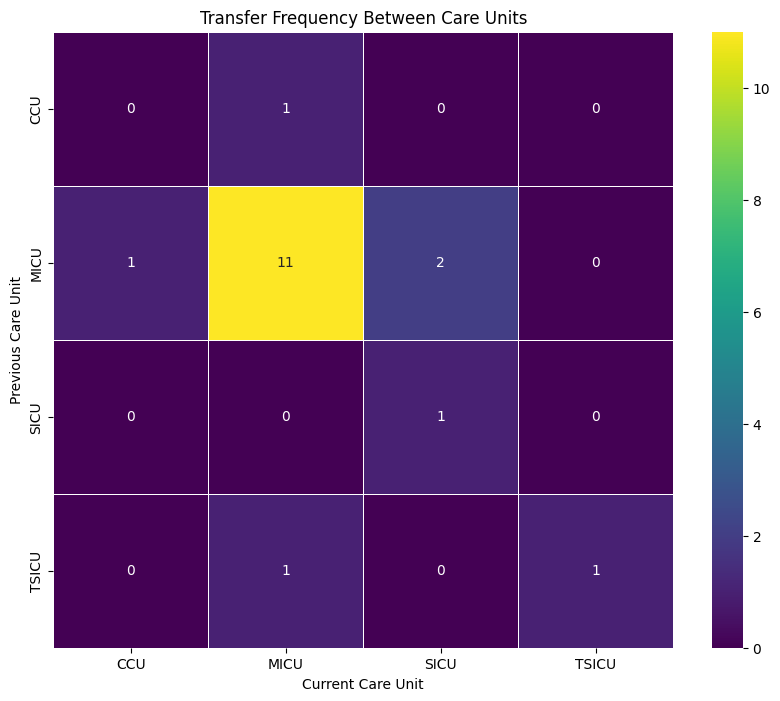

In [15]:
heatmap_data = transfer_counts.pivot(index='prev_careunit',columns='curr_careunit',values='count').fillna(0)

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=True,
    fmt='g',
    linewidths=0.5
)
plt.title("Transfer Frequency Between Care Units")
plt.xlabel("Current Care Unit")
plt.ylabel("Previous Care Unit")
plt.show()

In [16]:
icu_stays = transfers_df[transfers_df['curr_careunit'].str.contains('ICU', case=False, na=False)]

fig = px.box(icu_stays,x='curr_careunit',y='los_hours',
    labels={'curr_careunit': 'ICU Unit', 'los_hours': 'Length of Stay (Hours)'},
    title="<b>Length of Stay in ICU Units</b>",
    color='curr_careunit',
    width=1200,  
    height=1000  
)


fig.update_layout(
    showlegend=False,
    font_size=14,
    margin=dict(l=100, r=100, b=100, t=100), 
    xaxis=dict(
        title_font=dict(size=18), 
        tickfont=dict(size=14)    
    ),
    yaxis=dict(
        title_font=dict(size=18),  
        tickfont=dict(size=14)    
    )
)

fig.show()

C:\Users\ajays\AppData\Local\Temp\ipykernel_88480\686959823.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




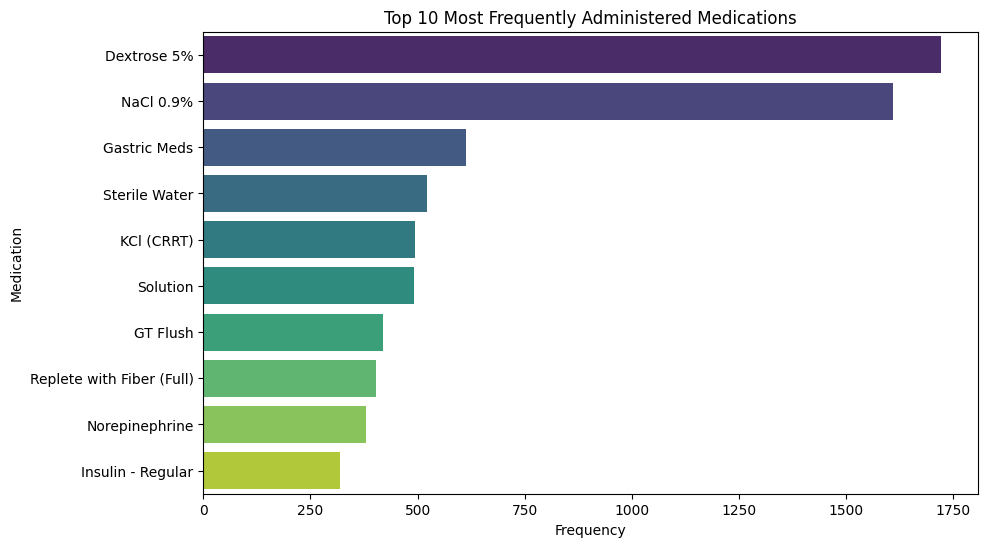

In [24]:
inputevents_df = pd.read_csv("INPUTEVENTS_MV.csv")
d_items_df = pd.read_csv("D_ITEMS.csv")
medication_df = inputevents_df.merge(d_items_df, on='itemid')
medication_frequency = medication_df['label'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=medication_frequency.values, y=medication_frequency.index, palette='viridis')
plt.title("Top 10 Most Frequently Administered Medications")
plt.xlabel("Frequency")
plt.ylabel("Medication")
plt.show()

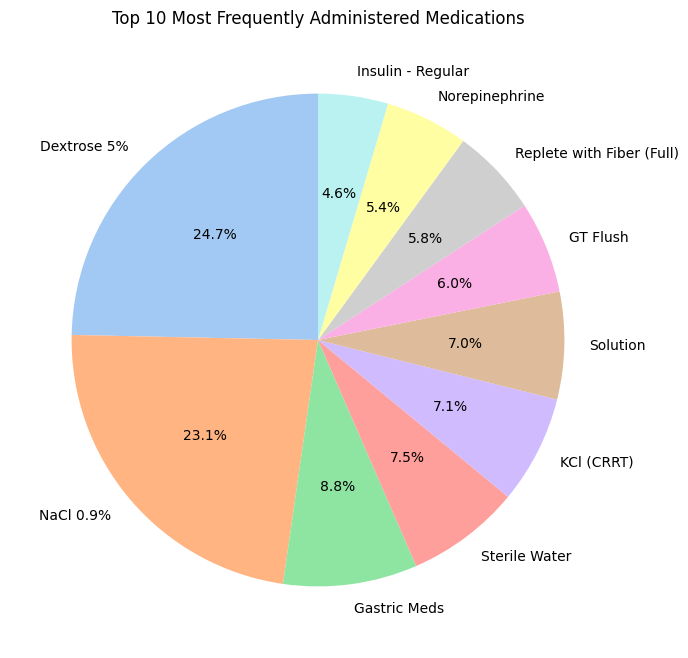

In [23]:

plt.figure(figsize=(8, 8))
medication_frequency.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("Top 10 Most Frequently Administered Medications")
plt.ylabel("")  
plt.show()

In [25]:
import plotly.express as px

fig = px.pie(medication_frequency, values=medication_frequency.values,names=medication_frequency.index,    
    title="Top 10 Most Frequently Administered Medications",
    hole=0.3, 
    color_discrete_sequence=px.colors.sequential.Viridis 
)

fig.update_traces(
    textposition='inside',  
    textinfo='percent+label'
)

fig.show()